<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://cdn.miami.edu/_assets-common/images/system/um-logo-gray-bg.png" alt="Miami Logo" style="height: 98px;">
</div>

<h1>MPO 624: Multivariate: LIM prediction and AR1 synthetic data</h1>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

### ENSO science from data 
1. <a href="#import">Importing data</a>
1. <a href="#anomaly">Remove mean seasonal cycle</a>
1. <a href="#covariance">Covariance matrix and lag-1 covariance</a>
1. <a href="#Mmatrix">The ratio: matrix M</a>
1. <a href="#prediction">exp(Mt) decay: predictions from an initial anomaly</a>
1. <a href="#synthetic">Synthetic realizations: exp(Mt) + noise</a>

## Generalizing the AR1 process ("red noise") to multiple dimensions

### AR1 red noise in 1 dimension

We saw in an earlier notebook [] that an AR1 time series (decay of anomalies T' from the previous time step plus noise) is a decent approximation to geophysical systems (like the ocean, Hasselman 1970s) that have some memory (integrators) and are forced by noise that acts like white (uncorrelated) random numbers. 

$$dT'/dt = aT' + W $$

Shedding the prime for clarity (*T is anomaly data hereafter*), and recasting the continuous form as a Markov chain (discrete time steps) on a data set ${T_i}$, we get 

$$ T_{t+1} = T_{t} \times \alpha + \epsilon $$

Why put the $\alpha$ after the T? No reason... for now. 

Use simple linear regression to estimate $\alpha$: Multiply the equation by $T'_{t}$ and average it. The **definition** of regression's $\alpha$ is the value that leaves no correlation of the predictor with the residual, so we are left with

$$ \overline{T_{t}T_{t+1}} = \overline{T_{t}T_{t}} \alpha $$

or 

$$ \alpha = (\overline{T_{t}T_{t}})^{-1} (\overline{T_{t}T_{t+1}})$$


### The vector-matrix version

Our coefficient $\alpha$ above becomes a *matrix* of coefficients, to be called a "model" **M** for the left side as a postulated function on the right side. Matrix multiplication is noncummutative, so **M** must sit on the right of the 'data table' matrices **T**: 

$$ \pmb{T_{t+1}} = \pmb{T_{t}} \pmb{M} + \pmb{\epsilon} $$


### Estimating (solving for) M

We need to left-multiply both sides by the **transpose** of $T_{t}$, to get a square (invertable) matrix. Again, the **M** we seek is *defined* by capturing all the correlation with T, so that no projection is left in the residual term. 

$$ \pmb{T_{t}}^T \pmb{T_{t+1}} = \pmb{T_{t}}^T \pmb{T_{t}} \pmb{M} + 0 $$

Then multiply by the inverse of the square matrix on the right to isolate M: 

$$ (\pmb{T_{t}}^T \pmb{T_{t}})^{-1}(\pmb{T_{t}}^T \pmb{T_{t+1}}) = (\pmb{T_{t}}^T \pmb{T_{t}})^{-1}(\pmb{T_{t}}^T \pmb{T_{t}}) \pmb{M} + 0 = \pmb{M} $$

### Notice the sameness
That's the power of matrix algebra -- it can look just like simple algebra, yet handle N-dimensional data! 

<a name="import"></a>
## Import our dataset (in current directory)

In [1]:
import numpy as np
from netCDF4 import Dataset

datafile = Dataset('Eq_timelon_sections.nc',mode='r')

# Trick: a loop over keys, building a command. Then, execute that command!

for key in datafile.variables.keys(): 
    print( key +"=datafile['"+key+"'][:].squeeze()") # to show the command
    exec( key +"=datafile['"+key+"'][:].squeeze()")
datafile.close()

yyyy = 1980.0 + (time + 0.5)/12. # 0.5 is the center of each month
np.shape(sst)

lon=datafile['lon'][:].squeeze()
time=datafile['time'][:].squeeze()
olr=datafile['olr'][:].squeeze()
precip=datafile['precip'][:].squeeze()
slp=datafile['slp'][:].squeeze()
sst=datafile['sst'][:].squeeze()
uwnd=datafile['uwnd'][:].squeeze()


(240, 144)

Populating the interactive namespace from numpy and matplotlib


//anaconda/envs/MPO624/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Text(0.5,1,'SST (C)')

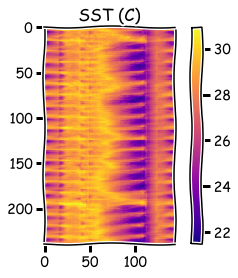

In [2]:
%pylab inline
plt.xkcd() # whiteboard style

imshow(sst, cmap='plasma'); colorbar(); title('SST (C)')

<a name="anomaly"></a>
## Remove seasonality

Seasonality's web of causality has all variables (all over the globe) forced by the sun. 

ENSO's web is different (along the equator, wind pushes the ocean, ocean SST drives convection, convection drives the wind -- a coupled system). 

**It is physically meaningless to study "variability" that is an unmanaged blend of a forced cycle and a free oscillation!**

(240, 144)

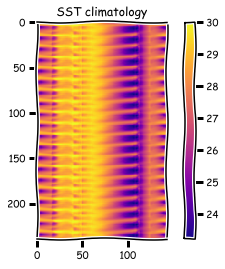

In [3]:
# I happen to know the data begin with a January. CAREFUL! Not a general approach
months = arange(size(yyyy)) 
calmos = arange(12) ## Runs from 0-11, not 1-12, CAREFUL! 

sstclim = np.zeros((12,np.size(lon))) ## Climatology Shaped Container

# Build it
for imo in calmos:
    yess = find(imo == months%12)
    sstclim[imo,:] = mean(sst[yess,:], axis=0 )

# Tile it out to make it the same shape as the data 
sstclim = np.tile(sstclim,(20,1))
imshow(sstclim, cmap='plasma'); colorbar(); title('SST climatology')
np.shape(sstclim)

(240, 144) (144,)


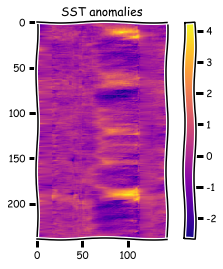

In [4]:
# Subtract climo and show anomaly
ssta = sst - sstclim
imshow(ssta, cmap='plasma'); colorbar(); title('SST anomalies')
print( np.shape(ssta), np.shape(lon) )

<a name="covariance"></a>
## Display a temporal covariance matrix

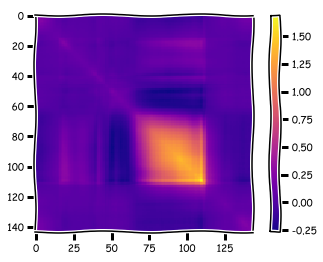

In [5]:
cormat = np.corrcoef( np.transpose(ssta) )
covmat = np.cov( np.transpose(ssta) )

imshow(covmat, cmap='plasma'); colorbar()

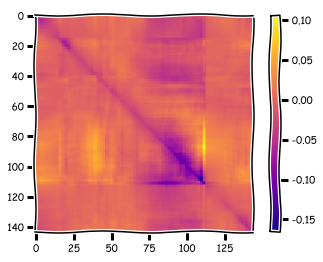

In [6]:
# Build cov and lagged cov from matrix multiplication approach (mean has been removed)
# CAUTION: which direction to roll array (-1 or +1). **Test with outcome**

dTd = np.matmul( np.transpose(ssta), ssta)                    /len(yyyy)
dTdlag = np.matmul( np.transpose(ssta), roll(ssta,-1,axis=0))  /len(yyyy)

# Show that lagged covariance is not quite symmetric: 
imshow(dTdlag-dTd, cmap='plasma'); colorbar()

<a name="Mmatrix"></a>
--------------
## Build the matrix for 1-time-step prediction

Recalling from the introduction, 

$$ \pmb{M} = (\pmb{T_{t}}^T \pmb{T_{t}})^{-1}(\pmb{T_{t}}^T \pmb{T_{t+1}}) $$


Text(0.5,1,'1-month predictions each month')

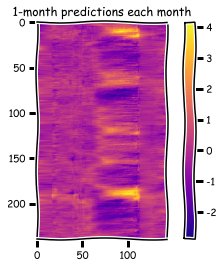

In [7]:
# The AR1 prediction

dTdinv = np.linalg.inv(dTd)
M = np.matmul(dTdinv, dTdlag)

prediction = np.matmul(ssta, M)
pred_err = ssta - prediction

imshow(prediction, cmap='plasma'); colorbar()
title('1-month predictions each month')

<a name="prediction"></a>
--------------
## Make multi-month predictions 
### with successive M multiplications

Notice that the exponential solution to the governing matrix differential equation without noise 

$$d\pmb{T}/dt = \pmb{TM}$$

is 

$$\pmb{T}=\pmb{T_0} exp(\pmb{M}t)$$

It includes both exponential decay and oscillation, since the eigenvalues of **M** are complex. 

1995.2084


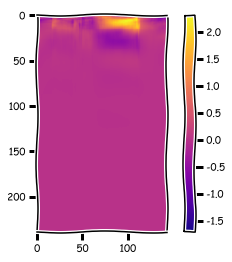

In [8]:
# Optimal (decaying) prediction over time from a random initial state 

ssta_syn = ssta*0 # answer shaped container

# Initial value randomly selected from SSTA data 
randomtindex = int( np.random.uniform(low=0, high=np.size(yyyy)-1) )
print(yyyy[randomtindex])
ssta_syn[0,:] = ssta[randomtindex,:]

for i in np.arange(size(yyyy)-1) + 1: 
    ssta_syn[i,:] = np.matmul(ssta_syn[i-1,:], M)
    
imshow(ssta_syn, cmap='plasma'); colorbar()

<a name="synthetic"></a>
-----------------
# Synthetic data: 
### starting state, then prediction, + random noise
(could start from SSTA=0, it's not that different)

Text(0.5,1,'Synthetic realization 20yr AR1')

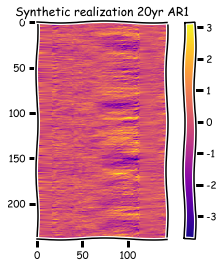

In [9]:
ssta_syn = ssta*0 # answer shaped container

# Initial value randomly selected from SSTA data 
randomtindex = int( np.random.uniform(low=0, high=np.size(yyyy)-1) )
ssta_syn[randomtindex,:] = ssta[randomtindex,:]

# March forward in time, sampling noise randomly from the 1-month prediction errors:
for i in np.arange(size(yyyy)-1) + 1: 
    randomtindex = int( np.random.uniform(low=0, high=np.size(yyyy)-1) )
    ssta_syn[i,:] = np.matmul(ssta_syn[i-1,:], M) + pred_err[randomtindex,:]

# Show the result
imshow(ssta_syn, cmap='plasma'); colorbar(); title('Synthetic realization 20yr AR1')